# 1.PosteriorDB

In [2]:
from posteriordb import PosteriorDatabase
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
pdb_path = f"{os.environ['MCMC_WORKDIR']}/posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

In [4]:
# posterior = my_pdb.posterior("eight_schools-eight_schools_centered")
posterior = my_pdb.posterior("eight_schools-eight_schools_noncentered")

pmodel = posterior.model
pdata = posterior.data

In [5]:
pmodel.information

{'name': 'eight_schools_noncentered',
 'title': 'A non-centered hiearchical model for 8 schools',
 'description': 'A non-centered hiearchical model for the 8 schools example of Rubin (1981)',
 'keywords': 'hiearchical',
 'references': ['rubin1981estimation', 'gelman2013bayesian'],
 'urls': 'http://www.stat.columbia.edu/~gelman/arm/examples/schools',
 'prior': {'keywords': []},
 'added_by': 'Mans Magnusson',
 'added_date': '2019-08-12'}

In [6]:
print(pmodel.code("stan"))

data {
  int<lower=0> J; // number of schools
  array[J] real y; // estimated treatment
  array[J] real<lower=0> sigma; // std of estimated effect
}
parameters {
  vector[J] theta_trans; // transformation of theta
  real mu; // hyper-parameter of mean
  real<lower=0> tau; // hyper-parameter of sd
}
transformed parameters {
  vector[J] theta;
  // original theta
  theta = theta_trans * tau + mu;
}
model {
  theta_trans ~ normal(0, 1);
  y ~ normal(theta, sigma);
  mu ~ normal(0, 5); // a non-informative prior
  tau ~ cauchy(0, 5);
}





In [7]:
pdata.information

{'name': 'eight_schools',
 'keywords': ['bda3_example'],
 'title': 'The 8 schools dataset of Rubin (1981)',
 'description': 'A study for the Educational Testing Service to analyze the effects of\nspecial coaching programs on test scores. See Gelman et. al. (2014), Section 5.5 for details.',
 'urls': ['http://www.stat.columbia.edu/~gelman/arm/examples/schools'],
 'references': ['rubin1981estimation', 'gelman2013bayesian'],
 'added_by': 'Mans Magnusson',
 'added_date': '2019-08-12'}

In [8]:
posterior.information

{'keywords': ['stan benchmark', 'pathfinder paper'],
 'dimensions': {'theta': 8, 'mu': 1, 'tau': 1},
 'added_by': 'Mans Magnusson',
 'added_date': '2019-08-12'}

In [9]:
posterior.reference_draws_info()

{'name': 'eight_schools-eight_schools_noncentered',
 'inference': {'method': 'stan_sampling',
  'method_arguments': {'chains': 10,
   'iter': 20000,
   'warmup': 10000,
   'thin': 10,
   'seed': 4711,
   'control': {'adapt_delta': 0.95}}},
 'diagnostics': {'diagnostic_information': {'names': ['mu',
    'tau',
    'theta[1]',
    'theta[2]',
    'theta[3]',
    'theta[4]',
    'theta[5]',
    'theta[6]',
    'theta[7]',
    'theta[8]']},
  'ndraws': 10000,
  'nchains': 10,
  'effective_sample_size_bulk': [10041.0896201168,
   9989.27163956509,
   10095.2967716424,
   10048.7605290177,
   9533.22696994086,
   10026.3139529165,
   9921.76671546211,
   9782.69125918,
   10038.5121243522,
   9605.15453269234],
  'effective_sample_size_tail': [9973.47696505836,
   9992.18100324749,
   9732.47952723908,
   10139.1087989181,
   9338.98171714254,
   9665.77831222399,
   10206.5263539246,
   10038.5763550319,
   9689.92308837161,
   9870.88374609811],
  'r_hat': [0.99976115558753,
   0.999845473

In [10]:
reference_draws_df = pd.concat([pd.DataFrame(chain_draw).assign(chain_id=i) for i, chain_draw in enumerate(posterior.reference_draws())])

reference_draws_df.rename(columns={f"theta[{i + 1}]": f"theta[{i}]" for i in range(8)}, inplace=True)
var_cols = [f"theta[{i}]" for i in range(8)] + ["mu", "tau"]

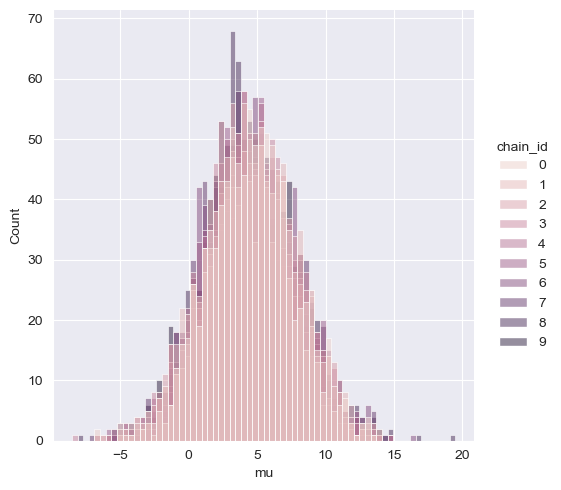

In [11]:
sns.displot(reference_draws_df, x="mu", hue="chain_id")

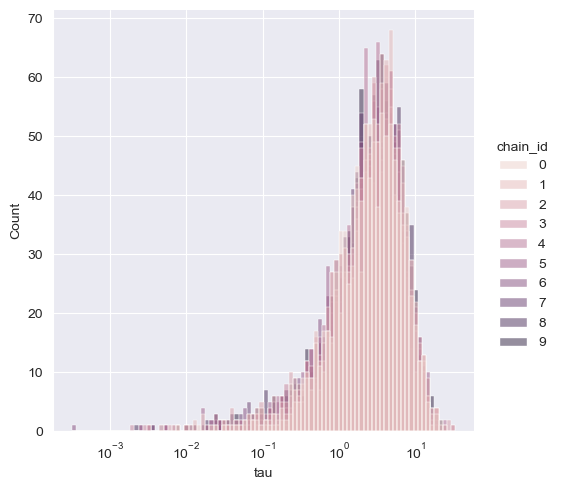

In [12]:
sns.displot(reference_draws_df, x="tau", hue="chain_id", log_scale=(10, None))

<Axes: >

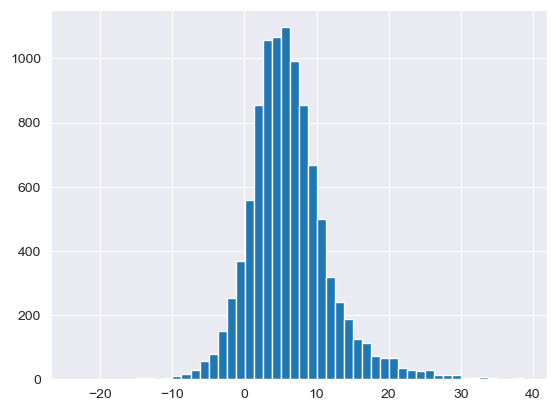

In [13]:
reference_draws_df["theta[0]"].hist(bins=50)

In [14]:
# reference_draws_df.drop(columns=["chain_id"], inplace=True)

# 2.NumPyro

In [15]:
import numpyro
import numpyro.distributions as dist
import jax 
from jax import random, vmap, jit
import jax.numpy as jnp
from numpyro import infer

from kernels import ARWMH, ASSS, NUTS

In [16]:
J = pdata.values()["J"]
data = {
    "sigma": jnp.array(pdata.values()["sigma"]),
    "y": jnp.array(pdata.values()["y"])
}

reference_draws = {
    "mu": jnp.array(reference_draws_df["mu"]),
    "tau": jnp.array(reference_draws_df["tau"]),
    "theta": jnp.array(reference_draws_df[[f"theta[{i}]" for i in range(8)]]), 
}

In [17]:
data

{'sigma': Array([15, 10, 16, 11,  9, 11, 10, 18], dtype=int32),
 'y': Array([28,  8, -3,  7, -1,  1, 18, 12], dtype=int32)}

In [18]:
reference_draws["theta_base"] = (reference_draws["theta"] - reference_draws["mu"][:, None]) / reference_draws["tau"][:, None]

In [19]:
print(pmodel.code("stan"))

data {
  int<lower=0> J; // number of schools
  array[J] real y; // estimated treatment
  array[J] real<lower=0> sigma; // std of estimated effect
}
parameters {
  vector[J] theta_trans; // transformation of theta
  real mu; // hyper-parameter of mean
  real<lower=0> tau; // hyper-parameter of sd
}
transformed parameters {
  vector[J] theta;
  // original theta
  theta = theta_trans * tau + mu;
}
model {
  theta_trans ~ normal(0, 1);
  y ~ normal(theta, sigma);
  mu ~ normal(0, 5); // a non-informative prior
  tau ~ cauchy(0, 5);
}





In [20]:
def model(sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', len(sigma)):
        with numpyro.handlers.reparam(config={'theta': infer.reparam.TransformReparam()}):
            theta = numpyro.sample(
                'theta', 
                dist.TransformedDistribution(dist.Normal(0,1), dist.transforms.AffineTransform(mu, tau))
            )
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

infer.inspect.render_model(model, model_args=(data["sigma"], ), render_distributions=True, filename=f"{os.environ['MCMC_WORKDIR']}/img/svg/model_eight_schools.svg")

In [21]:
# # Eight Schools model
# 
# def model_centered(sigma, y=None):
#     mu = numpyro.sample('mu', dist.Normal(0, 5))
#     tau = numpyro.sample('tau', dist.HalfCauchy(5))
#     with numpyro.plate('J', len(sigma)):
#         theta = numpyro.sample('theta', dist.Normal(mu, tau))
#         numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)
# 
# # infer.inspect.render_model(model, model_args=(data["sigma"], ), render_distributions=True, filename=f"{os.environ['MCMC_WORKDIR']}/img/svg/model_eight_schools_centered.svg")


In [22]:
def get_max_theta(theta, **rest_kwargs):
    return jnp.max(theta)


def get_min_theta(theta, **rest_kwargs):
    return jnp.min(theta)

ref_max_theta = jax.vmap(get_max_theta)(**reference_draws).mean()
ref_min_theta = jax.vmap(get_min_theta)(**reference_draws).mean()

(array([  1.,   1.,   0.,   1.,   0.,   1.,   0.,   2.,   1.,   2.,   2.,
          2.,   8.,  11.,  10.,  16.,  19.,  17.,  22.,  26.,  40.,  62.,
         68.,  99., 153., 180., 236., 258., 298., 399., 518., 581., 729.,
        778., 840., 911., 848., 759., 632., 480., 382., 264., 160.,  84.,
         50.,  26.,  13.,   8.,   1.,   1.]),
 array([-32.91346741, -31.93944168, -30.96541405, -29.99138832,
        -29.01736259, -28.04333496, -27.06930923, -26.09528351,
        -25.12125778, -24.14723206, -23.17320442, -22.1991787 ,
        -21.22515106, -20.25112534, -19.27709961, -18.30307388,
        -17.32904816, -16.35502052, -15.3809948 , -14.40696907,
        -13.43294144, -12.45891571, -11.48488998, -10.51086426,
         -9.53683662,  -8.5628109 ,  -7.58878517,  -6.61475754,
         -5.64073181,  -4.66670609,  -3.69268036,  -2.71865273,
         -1.744627  ,  -0.77059937,   0.20342636,   1.17745209,
          2.15147781,   3.12550354,   4.09952927,   5.07355499,
          6.047584

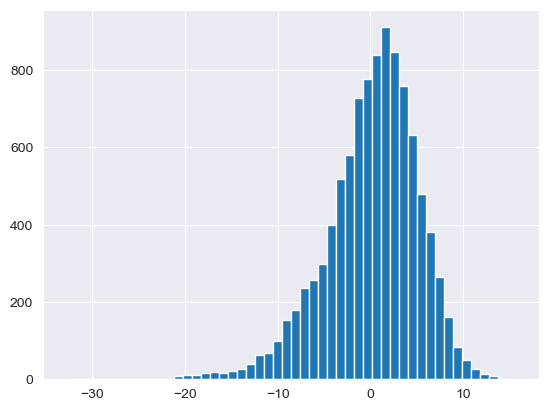

In [23]:
plt.hist(jax.vmap(get_min_theta)(**reference_draws), bins=50)

In [22]:
def get_pes(param_draws):
    leaves, treedef = jax.tree.flatten(param_draws)
    
    @jit
    def pe_model(*leaves):
        params = jax.tree.unflatten(treedef, leaves)
        log_density, _ = infer.util.log_density(model, model_args=(), model_kwargs=data, params=params)
        return -log_density
    
    pes = jax.vmap(pe_model)(*leaves)
    return pes

pe_offset = -jax.nn.logsumexp(-get_pes(reference_draws))
print(pe_offset.item())

36.37034225463867


In [23]:
get_offsetted_pes = lambda param_draws: get_pes(param_draws) - pe_offset

ref_pes = get_offsetted_pes(reference_draws)
reference_draws_df["potential_energy"] = ref_pes

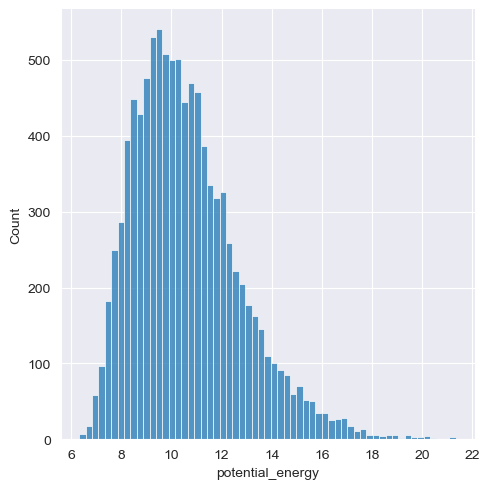

In [24]:
sns.displot(reference_draws_df, x="potential_energy")

In [25]:
%%time
kernel = NUTS(model)
mcmc = infer.MCMC(kernel, num_warmup=int(1e4), num_samples=int(1e5), thinning=10, progress_bar=False)
rng_key = random.PRNGKey(0)

mcmc.run(rng_key, extra_fields=('potential_energy',), **data)
print(mcmc.get_extra_fields()["potential_energy"].min())

mcmc.print_summary()


40.93256

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.36      3.33      4.40     -1.05      9.82   9899.95      1.00
          tau      3.63      3.21      2.82      0.00      7.71   9920.43      1.00
theta_base[0]      0.31      0.99      0.31     -1.40      1.84  10128.97      1.00
theta_base[1]      0.10      0.94      0.10     -1.44      1.64   9882.65      1.00
theta_base[2]     -0.08      0.98     -0.08     -1.67      1.55  10189.91      1.00
theta_base[3]      0.06      0.95      0.06     -1.45      1.64   9742.99      1.00
theta_base[4]     -0.16      0.93     -0.15     -1.72      1.33  10175.41      1.00
theta_base[5]     -0.06      0.94     -0.06     -1.68      1.41   9245.72      1.00
theta_base[6]      0.37      0.96      0.39     -1.23      1.93   9887.37      1.00
theta_base[7]      0.07      0.98      0.07     -1.56      1.66   9446.95      1.00

Number of divergences: 4
CPU times: user 13.2 s, sys: 1.73 s, tot

In [26]:
%%time
kernel = ARWMH(model)
mcmc = infer.MCMC(kernel, num_warmup=int(5e4), num_samples=int(5e5), thinning=50, progress_bar=False)
rng_key = random.PRNGKey(0)

mcmc.run(rng_key, extra_fields=('potential_energy',), **data)
print(mcmc.get_extra_fields()["potential_energy"].min())

mcmc.print_summary()

40.975197

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.40      3.29      4.44     -0.96      9.84   8787.29      1.00
          tau      3.63      3.21      2.81      0.00      7.72   8866.82      1.00
theta_base[0]      0.32      0.99      0.33     -1.28      1.93   9080.20      1.00
theta_base[1]      0.08      0.93      0.09     -1.48      1.57   8919.05      1.00
theta_base[2]     -0.09      0.95     -0.08     -1.62      1.51   8305.32      1.00
theta_base[3]      0.05      0.94      0.06     -1.53      1.52   8798.70      1.00
theta_base[4]     -0.16      0.92     -0.17     -1.67      1.31   9130.29      1.00
theta_base[5]     -0.09      0.94     -0.09     -1.65      1.45   9527.81      1.00
theta_base[6]      0.36      0.94      0.36     -1.17      1.92   8791.34      1.00
theta_base[7]      0.08      0.96      0.10     -1.45      1.67   9331.12      1.00

CPU times: user 18.4 s, sys: 2.75 s, total: 21.1 s
Wall time: 9.

In [27]:
%%time
kernel = ASSS(model)
mcmc = infer.MCMC(kernel, num_warmup=int(2.5e4), num_samples=int(2.5e5), thinning=25, progress_bar=False)
rng_key = random.PRNGKey(0)

mcmc.run(rng_key, extra_fields=('potential_energy',), **data)
print(mcmc.get_extra_fields()["potential_energy"].min())

mcmc.print_summary()

41.17326

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.46      3.30      4.49     -0.96      9.79  10281.46      1.00
          tau      3.54      3.20      2.67      0.00      7.67   9925.91      1.00
theta_base[0]      0.31      0.98      0.31     -1.29      1.94   9999.45      1.00
theta_base[1]      0.08      0.93      0.08     -1.39      1.65   9498.15      1.00
theta_base[2]     -0.08      0.98     -0.07     -1.65      1.55   9274.97      1.00
theta_base[3]      0.06      0.96      0.06     -1.59      1.55   9882.32      1.00
theta_base[4]     -0.18      0.94     -0.19     -1.77      1.31   9963.58      1.00
theta_base[5]     -0.07      0.94     -0.08     -1.66      1.39   9644.81      1.00
theta_base[6]      0.35      0.97      0.37     -1.19      2.00  10101.15      1.00
theta_base[7]      0.06      0.98      0.07     -1.50      1.68   9549.19      1.00

CPU times: user 12.1 s, sys: 649 ms, total: 12.8 s
Wall time: 6.4

In [28]:
posterior_samples = mcmc.get_samples()
extra_fields = mcmc.get_extra_fields()

In [29]:
posterior_samples

{'mu': Array([5.9806843, 8.043823 , 6.996377 , ..., 3.0281546, 5.3232265,
        3.1321294], dtype=float32),
 'tau': Array([0.03343812, 0.39051378, 1.5448252 , ..., 3.1258738 , 3.5171406 ,
        0.20670508], dtype=float32),
 'theta': Array([[5.9605246 , 6.0689573 , 5.9434233 , ..., 5.940227  , 6.0525174 ,
         6.0200186 ],
        [8.08116   , 8.3889885 , 7.391103  , ..., 7.8470793 , 8.039235  ,
         8.974663  ],
        [6.7083755 , 6.010228  , 1.3432349 , ..., 5.113281  , 5.106174  ,
         6.387495  ],
        ...,
        [4.400413  , 3.1111844 , 0.982156  , ..., 0.9619857 , 9.245234  ,
         7.341364  ],
        [4.729045  , 1.8955331 , 0.24953435, ..., 9.0372095 , 7.1163516 ,
         3.5614939 ],
        [3.0143075 , 3.0168016 , 3.077856  , ..., 2.821378  , 3.3349414 ,
         2.8953085 ]], dtype=float32),
 'theta_base': Array([[-0.6028933 ,  2.639894  , -1.1143339 , ..., -1.2099158 ,
          2.148244  ,  1.1763291 ],
        [ 0.09560811,  0.8838757 , -1.6714

In [30]:
posterior_samples_df = pd.DataFrame({
    "theta[0]": posterior_samples["theta"][:,0],
    "theta[1]": posterior_samples["theta"][:,1],
    "theta[2]": posterior_samples["theta"][:,2],
    "theta[3]": posterior_samples["theta"][:,3],
    "theta[4]": posterior_samples["theta"][:,4],
    "theta[5]": posterior_samples["theta"][:,5],
    "theta[6]": posterior_samples["theta"][:,6],
    "theta[7]": posterior_samples["theta"][:,7],
    
    "mu": posterior_samples["mu"],
    "tau": posterior_samples["tau"],
    
    "potential_energy": extra_fields["potential_energy"] - pe_offset,
    "step": jnp.repeat(jnp.arange(0, mcmc.num_samples, mcmc.thinning) + mcmc.thinning, mcmc.num_chains),
})

<Axes: xlabel='step', ylabel='log_tau'>

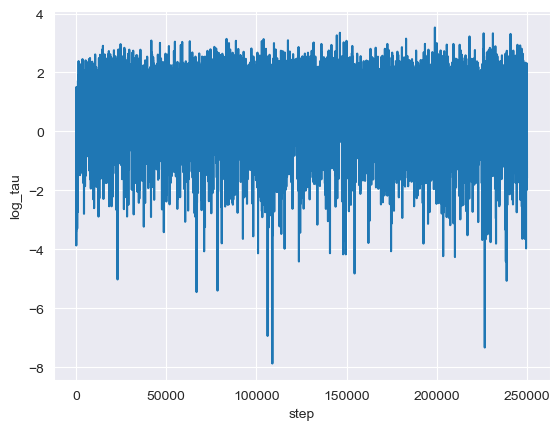

In [31]:
posterior_samples_df["log_tau"] = np.log(posterior_samples_df["tau"])
sns.lineplot(posterior_samples_df, x="step", y="log_tau")
# plt.semilogy()

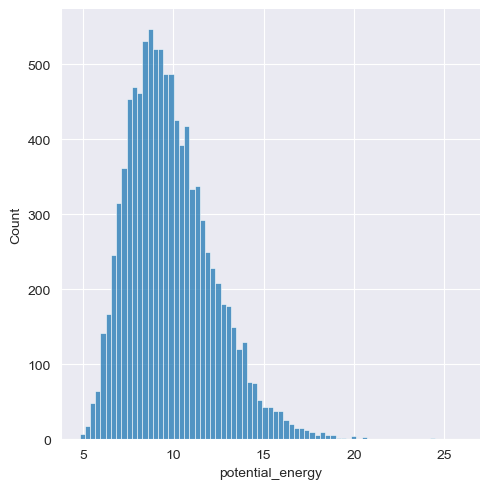

In [32]:
sns.displot(posterior_samples_df, x="potential_energy")

In [29]:
svg_dir = f"{os.environ['MCMC_WORKDIR']}/img/svg/"

### 2.2.2. PE

In [45]:
from utils.kernel_utils import ns_logscale

ns = ns_logscale(6)

In [46]:
import pickle
def open_pes(algo, decay):
    for i in range(100):
        with open(f"{os.environ['MCMC_WORKDIR']}/python/mcmc_runs/lr_decay/eight_schools/{algo}/{decay}/run{i}.pkl",
                  "rb") as f:
            states = pickle.load(f)
            yield states.potential_energy


In [47]:
pes_rwm = dict(
    pes1 = jnp.stack(list(open_pes("rwm", "1"))),
    pes2_3 = jnp.stack(list(open_pes("rwm", "2_3"))),
    pes1_2 = jnp.stack(list(open_pes("rwm", "1_2"))),
)
print(pes_rwm["pes1_2"].min())

40.638832


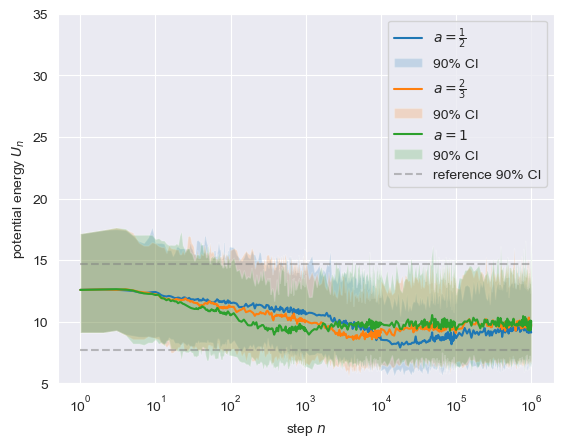

In [59]:
for a, a_l, pes in [
    (1/2, r"\frac{1}{2}", pes_rwm["pes1_2"]), 
    (2/3, r"\frac{2}{3}", pes_rwm["pes2_3"]), 
    (1, "1", pes_rwm["pes1"])
]:
    pes -= pe_offset

    pes_mean= pes.mean(axis=0)
    ci_l = jnp.quantile(pes, 0.05, axis=0)
    ci_u = jnp.quantile(pes, 0.95, axis=0)
    
    plt.plot(ns, pes_mean, label=rf"$a={a_l}$")
    plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI")
    
ci_ref_l = reference_draws_df["potential_energy"].quantile(0.05) 
ci_ref_u = reference_draws_df["potential_energy"].quantile(0.95)
plt.hlines([ci_ref_l, ci_ref_u], 1, 1e6, linestyles="--", color="gray", alpha=0.5, label="reference 90% CI")

plt.xlabel(r"step $n$")
plt.ylabel(r"potential energy $U_n$")

plt.legend(loc="upper right")
plt.ylim(5, 35)

# plt.semilogy()
plt.semilogx()

plt.savefig(svg_dir + "rwm-pe-lr-eight-schools.svg", format="svg")

In [51]:
pes_sss = dict(
    pes1 = jnp.stack(list(open_pes("sss", "1"))),
    pes2_3 = jnp.stack(list(open_pes("sss", "2_3"))),
    pes1_2 = jnp.stack(list(open_pes("sss", "1_2"))),
)
print(pes_sss["pes1_2"].min())

40.7964


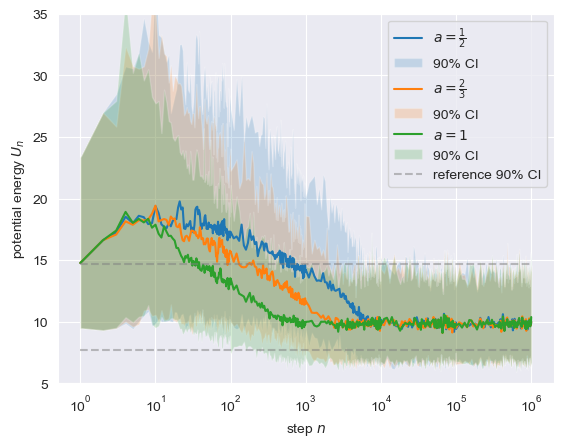

In [60]:
for a, a_l, pes in [
    (1/2, r"\frac{1}{2}", pes_sss["pes1_2"]), 
    (2/3, r"\frac{2}{3}", pes_sss["pes2_3"]), 
    (1, "1", pes_sss["pes1"])
]:
    pes -= pe_offset

    pes_mean= pes.mean(axis=0)
    ci_l = jnp.quantile(pes, 0.05, axis=0)
    ci_u = jnp.quantile(pes, 0.95, axis=0)
    
    plt.plot(ns, pes_mean, label=rf"$a={a_l}$")
    plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI")
    
ci_ref_l = reference_draws_df["potential_energy"].quantile(0.05)
ci_ref_u = reference_draws_df["potential_energy"].quantile(0.95)
plt.hlines([ci_ref_l, ci_ref_u], 1, 1e6, linestyles="--", color="gray", alpha=0.5, label="reference 90% CI")

plt.xlabel(r"step $n$")
plt.ylabel(r"potential energy $U_n$")

plt.legend(loc="upper right")
plt.ylim(5, 35)

# plt.semilogy()
plt.semilogx()

plt.savefig(svg_dir + "sss-pe-lr-eight-schools.svg", format="svg")

### 2.2.3. Adaptation

In [61]:
import pickle
def open_diffs(algo, decay):
    for i in range(100):
        with open(f"{os.environ['MCMC_WORKDIR']}/python/mcmc_runs/lr_decay/eight_schools/{algo}/{decay}/run{i}.pkl",
                  "rb") as f:
            states = pickle.load(f)
            yield states.as_change

In [62]:
diffs_rwm = dict(
    diffs1=jnp.stack(list(open_diffs("rwm", "1"))),
    diffs2_3=jnp.stack(list(open_diffs("rwm", "2_3"))),
    diffs1_2=jnp.stack(list(open_diffs("rwm", "1_2"))),
)

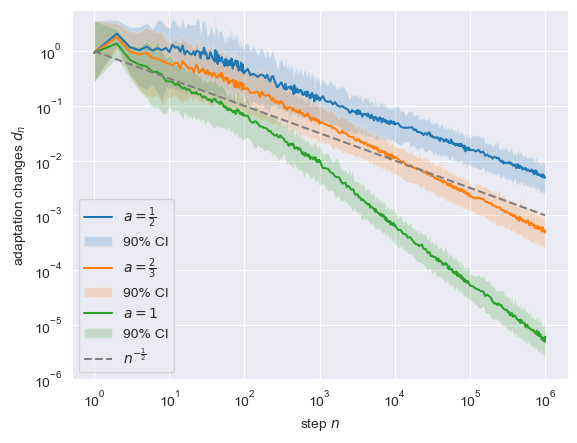

In [63]:
for a, a_l, diffs in [
    (1/2, r"\frac{1}{2}", diffs_rwm["diffs1_2"]), 
    (2/3, r"\frac{2}{3}", diffs_rwm["diffs2_3"]), 
    (1, "1", diffs_rwm["diffs1"])
]:
    diffs_mean= jnp.mean(diffs, axis=0)
    ci_l = jnp.quantile(diffs, 0.05, axis=0)
    ci_u = jnp.quantile(diffs, 0.95, axis=0)
    
    plt.plot(ns, diffs_mean, label=rf"$a={a_l}$")
    plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI")

plt.plot(ns, 1 / jnp.sqrt(ns), "--", color="gray", label=r"$n^{-\frac{1}{2}}$")

plt.xlabel(r"step $n$")
plt.ylabel(r"adaptation changes $d_n$")

plt.legend(loc="lower left")

plt.ylim(bottom=1e-6)
plt.semilogy()
plt.semilogx()

plt.savefig(svg_dir + "rwm-adaptation-lr-eight-schools.svg", format="svg")
# plt.savefig(png_dir + "sss-adaptation-lr-diamonds.png", format="png", dpi=300)

In [64]:
diffs_sss = dict(
    diffs1=jnp.stack(list(open_diffs("sss", "1"))),
    diffs2_3=jnp.stack(list(open_diffs("sss", "2_3"))),
    diffs1_2=jnp.stack(list(open_diffs("sss", "1_2"))),
)

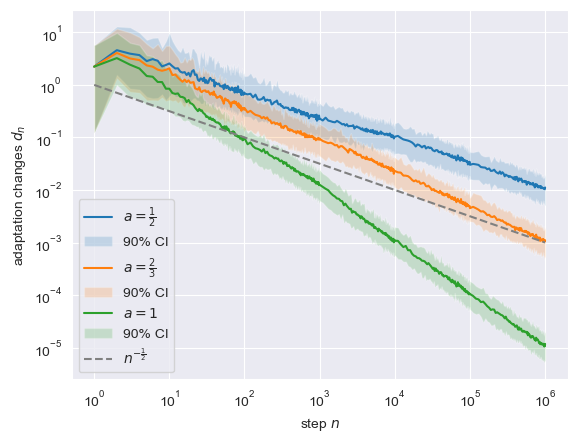

In [65]:
for a, a_l, diffs in [
    (1/2, r"\frac{1}{2}", diffs_sss["diffs1_2"]), 
    (2/3, r"\frac{2}{3}", diffs_sss["diffs2_3"]), 
    (1, "1", diffs_sss["diffs1"])
]:
    diffs_mean= diffs.mean(axis=0)
    ci_l = jnp.quantile(diffs, 0.05, axis=0)
    ci_u = jnp.quantile(diffs, 0.95, axis=0)
    
    plt.plot(ns, diffs_mean, label=rf"$a={a_l}$")
    plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI")

plt.plot(ns, 1 / jnp.sqrt(ns), "--", color="gray", label=r"$n^{-\frac{1}{2}}$")

plt.xlabel(r"step $n$")
plt.ylabel(r"adaptation changes $d_n$")

plt.legend(loc="lower left")

plt.semilogy()
plt.semilogx()

plt.savefig(svg_dir + "sss-adaptation-lr-eight-schools.svg", format="svg")
# plt.savefig(png_dir + "sss-adaptation-lr-diamonds.png", format="png", dpi=300)

### 2.2.4 Eccentricity

In [99]:
# ref_mus, ref_taus, ref_thetas, ref_thetas_base = jax.tree.leaves(reference_draws)
# @jax.jit
# def ecc(mu, tau, theta_base, **rest_kwargs):
#     ecc_theta = jnp.linalg.vector_norm(theta_base[None] - ref_thetas_base, axis=1).mean(axis=0)
#     ecc_mu = jnp.abs(mu[None] - ref_mus).mean(axis=0)
#     ecc_tau = jnp.abs(tau[None] - jnp.log(ref_taus)).mean(axis=0)
#     return ecc_theta + ecc_mu + ecc_tau

In [104]:
# ref_eccs = vmap(ecc)(**reference_draws)

In [105]:
# import pickle
# def open_eccs(algo, decay):
#     for i in range(100):
#         with open(f"{os.environ['MCMC_WORKDIR']}/python/mcmc_runs/lr_decay/eight_schools/{algo}/{decay}/run{i}.pkl",
#                   "rb") as f:
#             states = pickle.load(f)
#             # leaves = jax.tree.leaves(states.z)
#             eccs = vmap(ecc)(**states.z)
#             yield eccs

In [106]:
# eccs_rwm = dict(
#     eccs1 = jnp.stack(list(open_eccs("rwm", "1"))),
#     eccs2_3 = jnp.stack(list(open_eccs("rwm", "2_3"))),
#     eccs1_2 = jnp.stack(list(open_eccs("rwm", "1_2"))),
# )
# print(eccs_rwm["eccs1_2"].min())

In [107]:
# for a, a_l, eccs in [
#     (1/2, r"\frac{1}{2}", eccs_rwm["eccs1_2"]), 
#     (2/3, r"\frac{2}{3}", eccs_rwm["eccs2_3"]), 
#     (1, "1", eccs_rwm["eccs1"])
# ]:
#     eccs_mean= jnp.mean(eccs, axis=0)
#     ci_l = jnp.quantile(eccs, 0.05, axis=0)
#     ci_u = jnp.quantile(eccs, 0.95, axis=0)
#     
#     plt.plot(ns, eccs_mean, label=rf"$a={a_l}$")
#     plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI")
# 
# ci_ref_l = jnp.quantile(ref_eccs, 0.05) 
# ci_ref_u = jnp.quantile(ref_eccs, 0.95)
# plt.hlines([ci_ref_l, ci_ref_u], 1, 1e6, linestyles="--", color="gray", alpha=0.5, label="reference 90% CI")
# 
# 
# plt.xlabel(r"step $n$")
# plt.ylabel(r"eccentricity $E(X_n)$")
# 
# plt.legend(loc="lower left")
# 
# # plt.ylim(bottom=1e-6)
# plt.semilogy()
# plt.semilogx()
# 
# # plt.savefig(svg_dir + "rwm-ecc-lr-eight-schools.svg", format="svg")

In [108]:
# eccs_sss = dict(
#     eccs1 = jnp.stack(list(open_eccs("sss", "1"))),
#     eccs2_3 = jnp.stack(list(open_eccs("sss", "2_3"))),
#     eccs1_2 = jnp.stack(list(open_eccs("sss", "1_2"))),
# )
# print(eccs_sss["eccs1_2"].min())

In [109]:
# for a, a_l, eccs in [
#     (1/2, r"\frac{1}{2}", eccs_sss["eccs1_2"]), 
#     (2/3, r"\frac{2}{3}", eccs_sss["eccs2_3"]), 
#     (1, "1", eccs_sss["eccs1"])
# ]:
#     eccs_mean= jnp.mean(eccs, axis=0)
#     ci_l = jnp.quantile(eccs, 0.05, axis=0)
#     ci_u = jnp.quantile(eccs, 0.95, axis=0)
#     
#     plt.plot(ns, eccs_mean, label=rf"$a={a_l}$")
#     plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI")
# 
# ci_ref_l = jnp.quantile(ref_eccs, 0.05) 
# ci_ref_u = jnp.quantile(ref_eccs, 0.95)
# plt.hlines([ci_ref_l, ci_ref_u], 1, 1e6, linestyles="--", color="gray", alpha=0.5, label="reference 90% CI")
# 
# plt.xlabel(r"step $n$")
# plt.ylabel(r"eccentricity $E(X_n)$")
# 
# plt.legend(loc="lower left")
# 
# # plt.ylim(bottom=1e-6)
# plt.semilogy()
# plt.semilogx()
# 
# # plt.savefig(svg_dir + "rwm-ecc-lr-eight-schools.svg", format="svg")

# 3. Evaluation

In [24]:
palette = {
    "arwm": sns.color_palette("deep")[3],
    "asss": sns.color_palette("deep")[4],
    "nuts": sns.color_palette("deep")[5],
}

In [42]:
import pickle

runs_dir = f"{os.environ['MCMC_WORKDIR']}/python/mcmc_runs/w_eval/eight_schools"

def open_cummeans(algo):
    for run_key in range(100):
        with open(f"{runs_dir}/{algo}/run{run_key}.pkl", "rb") as f:
            mcmc = pickle.load(f)
        posterior_samples = mcmc.get_samples()

        fs = jax.vmap(get_min_theta)(**posterior_samples)
        f_cummean = jnp.cumsum(fs) / jnp.cumsum(jnp.ones_like(fs))
        yield f_cummean


cummeans = dict(
    arwm=jnp.stack(list(open_cummeans("rwm"))),
    asss=jnp.stack(list(open_cummeans("sss"))),
    nuts=jnp.stack(list(open_cummeans("nuts"))),
)


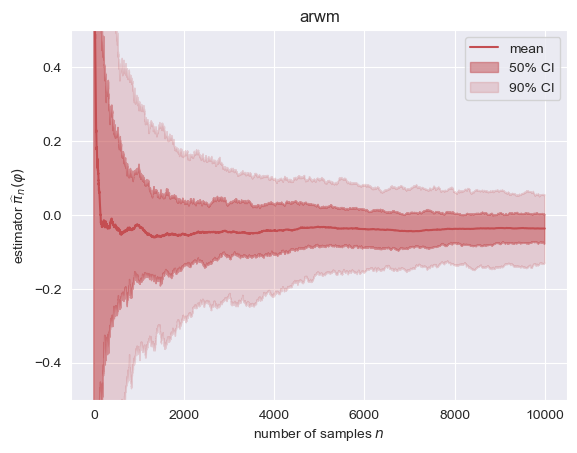

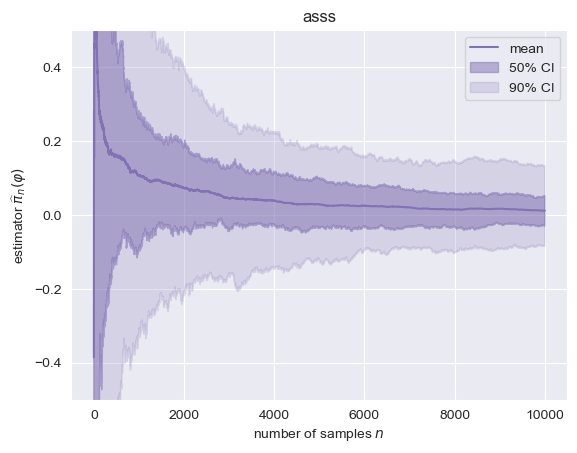

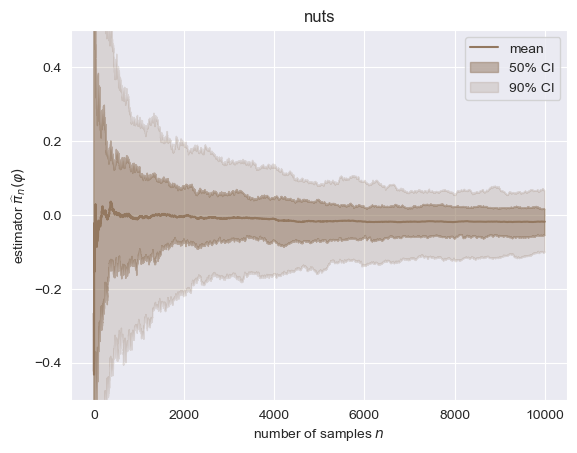

In [44]:
ns = jnp.arange(10000) + 1
for algo, f_cummean in cummeans.items():
    f_cummean -= ref_min_theta
    bias = f_cummean.mean(axis=0)
    ci_low = jnp.quantile(f_cummean, 0.25, axis=0) 
    ci_upp = jnp.quantile(f_cummean, 0.75, axis=0)
    ci_l = jnp.quantile(f_cummean, 0.05, axis=0)
    ci_u = jnp.quantile(f_cummean, 0.95, axis=0)

    plt.figure()
    plt.title(algo)
    plt.plot(ns, bias, label="mean", color=palette[algo])
    # plt.plot(ns, std, label=algo + " std", color=palette[algo])
    plt.fill_between(ns, ci_low, ci_upp, alpha=0.5, label="50% CI", color=palette[algo])
    plt.fill_between(ns, ci_l, ci_u, alpha=0.2, label="90% CI", color=palette[algo])
    plt.ylim(-.5, 0.5)
    plt.ylabel(r"estimator $\widehat{\pi}_n(\varphi) $")
    plt.xlabel(r"number of samples $n$")
    plt.legend(loc="upper right")
    plt.savefig(svg_dir + f"{algo}-phi-eval-eight-schools.svg", format="svg")

In [25]:
combined_df = pd.concat([
    reference_draws_df[var_cols + ["potential_energy"]].assign(source = "reference"),
    posterior_samples_df[var_cols + ["potential_energy"]].assign(source = "samples"),
])

KeyError: "['potential_energy'] not in index"

In [33]:
combined_df["log_tau"] = np.log(combined_df["tau"])

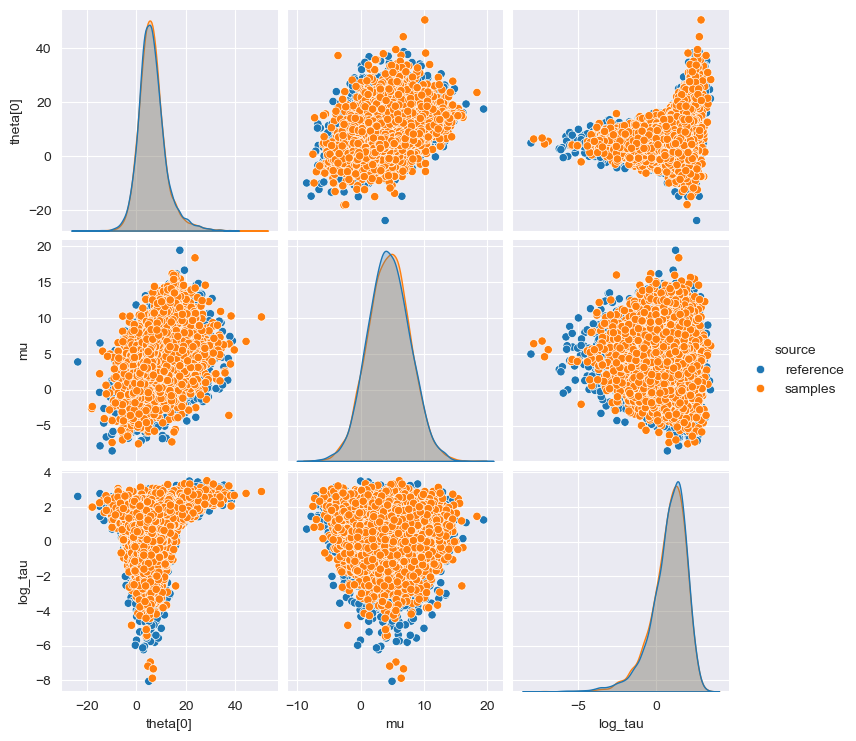

In [34]:
sns.pairplot(combined_df, vars=["theta[0]", "mu", "log_tau"], hue="source")


<Axes: xlabel='log_tau', ylabel='potential_energy'>

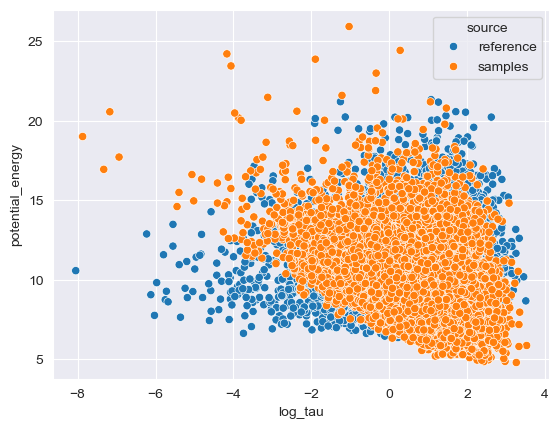

In [35]:
sns.scatterplot(combined_df, x="log_tau", y="potential_energy", hue="source")

In [26]:
df_eval = pd.concat([
    pd.read_csv(
        f"{os.environ['MCMC_WORKDIR']}/python/mcmc_runs/w_eval/eight_schools/eval_{algo}.csv",
        usecols=["rng_seed", "rmse_means", "wasserstein", "mmd"]
    ).assign(algorithm=(algo if algo=="nuts" else "a"+algo))
    for algo in ["rwm", "sss", "nuts"]
]).set_index(["algorithm", "rng_seed"])

In [27]:
sns.set_palette(sns.color_palette("deep")[3:6])

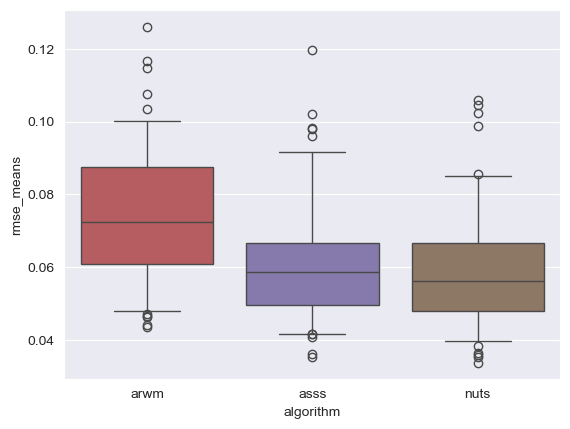

In [30]:
sns.boxplot(df_eval, x="algorithm", y="rmse_means", hue="algorithm", whis=[5,95])
# sns.stripplot(df_eval, x="algorithm", y="moment_rmse", size=3, hue="algorithm", alpha=0.5)
plt.savefig(svg_dir + "rmse-eval-eight-schools.svg", format="svg")

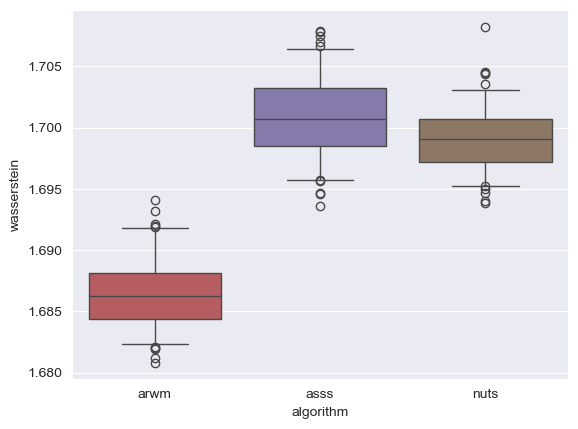

In [31]:
sns.boxplot(df_eval, x="algorithm", y="wasserstein", hue="algorithm", whis=[5,95])
# sns.stripplot(df_eval, x="algorithm", y="wasserstein", size=4, color="grey")
plt.savefig(svg_dir + "wasserstein-eval-eight-schools.svg", format="svg")

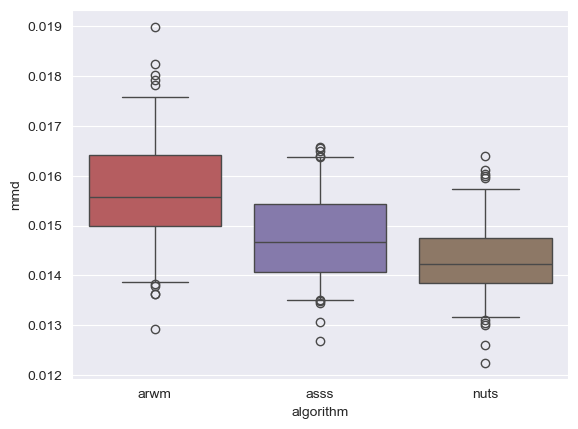

In [32]:
sns.boxplot(df_eval, x="algorithm", y="mmd", whis=[5,95], hue="algorithm")
# sns.stripplot(df_eval, x="algorithm", y="mmd2", size=4, color="grey")
plt.savefig(svg_dir + "mmd-eval-eight-schools.svg", format="svg")

In [33]:
df_eval_agg = df_eval.groupby(by=["algorithm"]).agg(["mean", "std"])
df_eval_agg

rmse_means           wasserstein                 mmd          
                mean       std        mean       std      mean       std
algorithm                                                               
arwm        0.074490  0.017705    1.686491  0.002820  0.015690  0.001119
asss        0.060667  0.014590    1.700887  0.003275  0.014782  0.000919
nuts        0.058666  0.015240    1.699175  0.002572  0.014306  0.000779